In [1]:
%load_ext tensorboard

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from pathlib import Path
import cv2

In [3]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from torch.nn import functional as F

### data

In [4]:
np.unique(plt.imread('D:\GeekBrains\pytorch\les03\data\mask\mask00000001.png')[:,:,0]*255)

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  71.,  72.,  74.,  75.,  76.,  78.,  86.,  93.,
       101.], dtype=float32)

In [5]:
lipsRGB = []
lipsSeg = []
for root, dirs, files in os.walk('D:\GeekBrains\pytorch\les03\data'):
    for name in files:
        f = os.path.join(root, name)
        if '720p' in f:
            lipsRGB.append(f)
        elif 'mask' in f:
            lipsSeg.append(f)
        else:
            break

In [6]:
# data_dict = {'lipsRGB': lipsRGB, 'lipsSeg': lipsSeg}
# min_length = min(len(data_dict['lipsRGB']), len(data_dict['lipsSeg']))
# min_length

In [7]:
mask = pd.DataFrame(lipsSeg, columns = ['lipsSeg'])
mask['ind'] = mask['lipsSeg'].replace(regex = True, to_replace = '.*\\\\' , value = '').replace(regex = True, to_replace = '\D' , value = '')
mask.set_index('ind')

lips = pd.DataFrame(lipsRGB, columns = ['lipsRGB'])
lips['ind'] = lips['lipsRGB'].replace(regex = True, to_replace = '.*\\\\' , value = '').replace(regex = True, to_replace = '\D' , value = '')
lips.set_index('ind')

,lipsRGB
ind,
00000001,D:\GeekBrains\pytorch\les03\data\720p\image000...
00000002,D:\GeekBrains\pytorch\les03\data\720p\image000...
00000003,D:\GeekBrains\pytorch\les03\data\720p\image000...
00000004,D:\GeekBrains\pytorch\les03\data\720p\image000...
00000005,D:\GeekBrains\pytorch\les03\data\720p\image000...
...,...
00028590,D:\GeekBrains\pytorch\les03\data\720p\image000...
00028591,D:\GeekBrains\pytorch\les03\data\720p\image000...
00028592,D:\GeekBrains\pytorch\les03\data\720p\image000...


In [8]:
df = lips.merge(mask).drop(['ind'], axis = 1)
# Отсортируем  датафрейм по значениям
df.sort_values(by='lipsRGB',inplace=True)
# Используем функцию,
# лагодаря которой индексация значений 
# будет начинаться с 0.
df.reset_index(drop=True, inplace=True)
# Выведем первые ять значений нашего датафрейма
print(df.head(5))

                                             lipsRGB  \
0  D:\GeekBrains\pytorch\les03\data\720p\image000...   
1  D:\GeekBrains\pytorch\les03\data\720p\image000...   
2  D:\GeekBrains\pytorch\les03\data\720p\image000...   
3  D:\GeekBrains\pytorch\les03\data\720p\image000...   
4  D:\GeekBrains\pytorch\les03\data\720p\image000...   

                                             lipsSeg  
0  D:\GeekBrains\pytorch\les03\data\bin_mask\mask...  
1  D:\GeekBrains\pytorch\les03\data\bin_mask_inve...  
2  D:\GeekBrains\pytorch\les03\data\mask\mask0000...  
3  D:\GeekBrains\pytorch\les03\data\new\mask00000...  
4  D:\GeekBrains\pytorch\les03\data\bin_mask\mask...  


In [9]:
df = df[:5000] # сократим количество примеров для экономии времени

In [10]:
def img_to_bin(read_path, write_path):
    img = cv2.cvtColor(cv2.imread(str(read_path)), cv2.COLOR_BGR2RGB)

    height, width, channels = img.shape
    img_binary = np.zeros((height,width,1))
    img_grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #grayscale
    (thresh, img_binary) = cv2.threshold(img_grayscale, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_binary = cv2.bitwise_not(img_binary) #invert img
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, img_binary)
    return new_path

In [11]:
# new_paths = []
# bin_path = Path('D:/GeekBrains/pytorch/les03/data/bin_mask_inverted/')
# for index, row in df.iterrows():
#     new_path = img_to_bin(Path(row['lipsSeg']), bin_path)
#     new_paths.append(new_path)
# df['lipsSeg_bin'] = new_paths

In [12]:
# df.head()

In [13]:
# df.to_csv('./paths_inverted.csv', index = False)

In [14]:
df = pd.read_csv("./paths_inverted.csv")
df

,lipsRGB,lipsSeg,lipsSeg_bin
0,D:\GeekBrains\pytorch\les03\data\720p\image000...,D:\GeekBrains\pytorch\les03\data\bin_mask\mask...,D:\GeekBrains\pytorch\les03\data\bin_mask_inve...
1,D:\GeekBrains\pytorch\les03\data\720p\image000...,D:\GeekBrains\pytorch\les03\data\mask\mask0000...,D:\GeekBrains\pytorch\les03\data\bin_mask_inve...
2,D:\GeekBrains\pytorch\les03\data\720p\image000...,D:\GeekBrains\pytorch\les03\data\new\mask00000...,D:\GeekBrains\pytorch\les03\data\bin_mask_inve...
3,D:\GeekBrains\pytorch\les03\data\720p\image000...,D:\GeekBrains\pytorch\les03\data\bin_mask\mask...,D:\GeekBrains\pytorch\les03\data\bin_mask_inve...
4,D:\GeekBrains\pytorch\les03\data\720p\image000...,D:\GeekBrains\pytorch\les03\data\mask\mask0000...,D:\GeekBrains\pytorch\les03\data\bin_mask_inve...
...,...,...,...
4995,D:\GeekBrains\pytorch\les03\data\720p\image000...,D:\GeekBrains\pytorch\les03\data\bin_mask\mask...,D:\GeekBrains\pytorch\les03\data\bin_mask_inve...
4996,D:\GeekBrains\pytorch\les03\data\720p\image000...,D:\GeekBrains\pytorch\les03\data\mask\mask0000...,D:\GeekBrains\pytorch\les03\data\bin_mask_inve...
4997,D:\GeekBrains\pytorch\les03\data\720p\image000...,D:\GeekBrains\pytorch\les03\data\mask\mask0000...,D:\GeekBrains\pytorch\les03\data\bin_mask_inve...
4998,D:\GeekBrains\pytorch\les03\data\720p\image000...,D:\GeekBrains\pytorch\les03\data\bin_mask\mask...,D:\GeekBrains\pytorch\les03\data\bin_mask_inve...


In [15]:
labels = ['lips']

[  0 255]


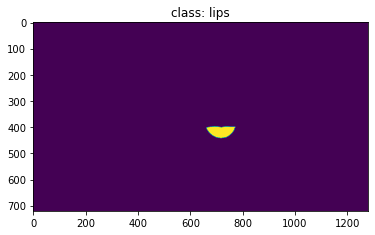

In [16]:
for i in range(1):
    mask = plt.imread('D:/GeekBrains/pytorch/les03/data/bin_mask_inverted/mask00000001.png')*255
    mask = np.where(mask == i, 255, 0)
#     mask = mask[:,:,0]
    print(np.unique(mask))
    plt.title(f'class: {labels[i]}')
    plt.imshow(mask)
    plt.show()

In [17]:
class CustomDatasetFromImages(Dataset):
    def __init__(self, data_info):
        # Подаем наш подготовленный датафрейм
        self.data_info = data_info
        
        # Разделяем датафрейм на rgb картинки 
        self.image_arr = self.data_info.iloc[:,0]
        # и на сегментированные картинки
        self.label_arr = self.data_info.iloc[:,2]
        
        # Количество пар картинка-сегментация
        self.data_len = len(self.data_info.index)
        
        # convert str names to class values on masks
        # Конвертируем стринговые имена в значения класса на маске
        self.class_values = [labels.index(cls) for cls in labels]
        
    def __getitem__(self, index):
        # Читаем картинку и сразу же представляем ее в виде numpy-массива 
        # размера 600х800 float-значний
        img = Image.open(self.image_arr[index])
        # Преобразовываем к размеру 256х256
        img = img.resize((256, 256))
        img = np.asarray(img).astype('float')
        # Нормализуем изображение в значениях [0,1]
        img = torch.as_tensor(img)/255    
        # Количество каналов ставим на первый план - этого хочет pytorch
        img = img.permute(2,0,1).float()
        
        # Считываем нашу маску
        mask = np.asarray(plt.imread(self.label_arr[index]))*255

        # Здесь мы создаем список бинарных масок из нашей одной общей маски 
        masks = [(mask == v) for v in self.class_values]
        # Стекаем все вместе в один многомерный тензор масок
        mask = np.stack(masks, axis=-1).astype('float')

        #  Приводим к типу тензора
        mask = torch.as_tensor(mask)

#         mask = mask.view(mask.shape[0], mask.shape[1], 1)
#         mask = torch.FloatTensor(mask[None,].type(torch.float32))
#         print(mask.size())
        # Размерность каналов на передний план
        mask = mask.permute(2, 0, 1)

        
        # делаем ресайз маски на 256х256
        # Для этого используем функцию interpolate
        ### Что бы ресайзить и высоту и ширину картинки, нужно перед interpolate
        ### пороизвести unsqueeze над тензором, и squeeze после.
        # unsqueeze - меняет размерность img c (256, 256, 3) -> (1, 256, 256, 3),
        mask = mask.unsqueeze(0)
        mask = F.interpolate(input=mask, size=256, mode='nearest')
        mask=mask.squeeze(0)
#         print(mask.size())

        
        return (img, mask)

    def __len__(self):
        return self.data_len

In [18]:
# sum(np.asarray(plt.imread(df.iloc[:,2][4]))[:, :]*255).sum()

In [19]:
from sklearn.model_selection import train_test_split

# 70 % в тренировочную выборку, 30 - в тестовую
X_train, X_test = train_test_split(df,test_size=0.3)

# Упорядочиваем индексацию
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

# Оборачиваем каждую выборку в наш кастомный датасет
train_data = CustomDatasetFromImages(X_train)
test_data = CustomDatasetFromImages(X_test)

In [20]:
train_data_loader = DataLoader(train_data,batch_size=8,shuffle=True)
test_data_loader = DataLoader(test_data,batch_size=5,shuffle=False)

In [21]:
sample = iter(train_data_loader).next()

In [22]:
sample[0].size()

torch.Size([8, 3, 256, 256])

In [23]:
sample[1].size()

torch.Size([8, 1, 256, 256])

In [24]:
sample[1][0].sum() #с маской все ок, есть и 0, и 1

tensor(151., dtype=torch.float64)

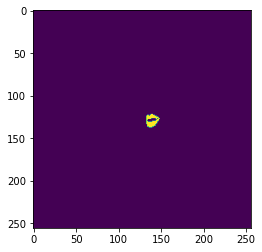

In [25]:
plt.imshow(sample[1][0].permute(1, 2, 0).detach().cpu().numpy())

### model

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [27]:
import segmentation_models_pytorch as smp
import time

# создание модели
segmodel = smp.Unet()
segmodel = smp.Unet('resnet34', encoder_weights='imagenet', classes=1, activation='softmax').to(device)

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.SGD([ 
    dict(params=segmodel.parameters(), lr=0.01, momentum=0.9),
])

train_epoch = smp.utils.train.TrainEpoch(
    segmodel, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    segmodel, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

max_score = 0

for i in range(0, 5):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_data_loader)
    valid_logs = valid_epoch.run(test_data_loader)
    
    # do something (save model, change lr, etc.)
#     if max_score < valid_logs['iou_score']:
#         max_score = valid_logs['iou_score']
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(segmodel, './best_smp_model.pth')
        print('Model saved!')
        
    if i == 3:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train:   0%|                                                                                   | 0/438 [00:00<?, ?it/s]

C:\Users\snetkova\Anaconda3\lib\site-packages\segmentation_models_pytorch\base\modules.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


valid: 100%|███████████████████████████████| 300/300 [01:09<00:00,  4.34it/s, dice_loss - 0.9905, iou_score - 0.004793]
Model saved!

Epoch: 1
valid: 100%|███████████████████████████████| 300/300 [01:15<00:00,  3.99it/s, dice_loss - 0.9905, iou_score - 0.004793]

Epoch: 2
valid: 100%|███████████████████████████████| 300/300 [01:15<00:00,  4.00it/s, dice_loss - 0.9905, iou_score - 0.004793]

Epoch: 3
valid: 100%|███████████████████████████████| 300/300 [01:15<00:00,  3.95it/s, dice_loss - 0.9905, iou_score - 0.004793]
Decrease decoder learning rate to 1e-5!

Epoch: 4
valid: 100%|███████████████████████████████| 300/300 [01:20<00:00,  3.75it/s, dice_loss - 0.9905, iou_score - 0.004793]


In [28]:
# valid_logs

In [29]:
# best_model = torch.load('./best_smp_model.pth')

In [30]:
# images, labels = iter(train_data_loader).next()
# labels[0].size()

In [31]:
# plt.imshow(labels[0].permute(1, 2, 0).detach().cpu().numpy())

### test

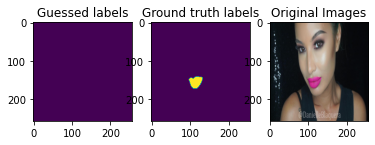

C:\Users\snetkova\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

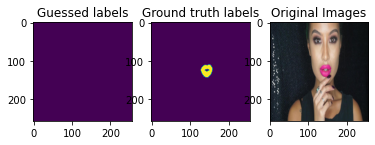

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

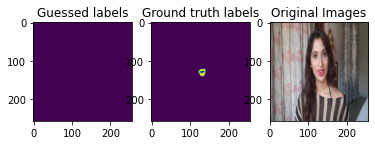

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

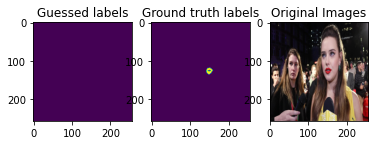

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

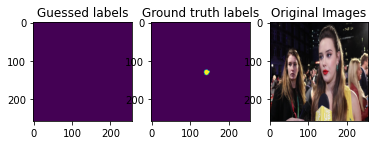

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

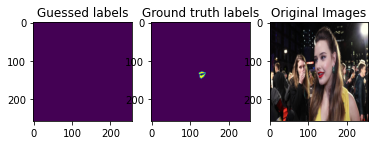

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

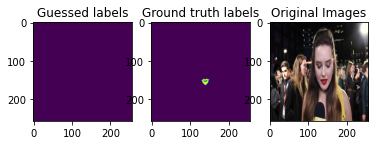

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [32]:
for i, data in enumerate(test_data_loader):
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    outputs = segmodel(images)
    f, axarr = plt.subplots(1,3)

    for j in range(0,5):
        axarr[0].imshow(outputs.squeeze().detach().cpu().numpy()[j,:,:])
        axarr[0].set_title('Guessed labels')

        axarr[1].imshow(labels[j].permute(1, 2, 0).detach().cpu().numpy())
        axarr[1].set_title('Ground truth labels')

        original = images[j].cpu().permute(1, 2, 0)
        axarr[2].imshow(original)
        axarr[2].set_title('Original Images')
        plt.show()
        plt.gcf().show()
    if i>5:
        break

In [33]:
# help(smp.utils.metrics)

In [34]:
# help(smp.utils.losses)